In [1]:
%matplotlib inline

# RNN by PyTorch


## NLP From Scratch: Classifying Names with a Character-Level RNN
**************************************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

We will be building and training a basic character-level RNN to classify
words. This tutorial, along with the following two, show how to do
preprocess data for NLP modeling "from scratch", in particular not using
many of the convenience functions of `torchtext`, so you can see how
preprocessing for NLP modeling works at a low level.

A character-level RNN reads words as a series of characters -
outputting a prediction and "hidden state" at each step, feeding its
previous hidden state into each next step. We take the final prediction
to be the output, i.e. which class the word belongs to.

Specifically, we'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling:

::

    $ python predict.py Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    $ python predict.py Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch


**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  https://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user

It would also be useful to know about RNNs and how they work:

-  `The Unreasonable Effectiveness of Recurrent Neural
   Networks <https://karpathy.github.io/2015/05/21/rnn-effectiveness/>`__
   shows a bunch of real life examples
-  `Understanding LSTM
   Networks <https://colah.github.io/posts/2015-08-Understanding-LSTMs/>`__
   is about LSTMs specifically but also informative about RNNs in
   general

## Preparing the Data
==================

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.

Included in the ``data/names`` directory are 18 text files named as
"[Language].txt". Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.



In [4]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']
Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [5]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [24]:
all_categories

['Arabic',
 'Chinese',
 'Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Japanese',
 'Korean',
 'Polish',
 'Portuguese',
 'Russian',
 'Scottish',
 'Spanish',
 'Vietnamese']

Turning Names into Tensors
--------------------------

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a "one-hot vector" of size
``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [6]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [20]:
line = "Jones"
tensor = torch.zeros(len(line), 1, n_letters)

In [21]:
tensor

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.,

Creating the Network
====================

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module is just 2 linear layers which operate on an input and hidden state, with
a LogSoftmax layer after the output.

In [7]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        hidden = self.tanh(hidden)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).




In [8]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
pre-computing batches of Tensors.




In [9]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)
print(next_hidden)

tensor([[-2.9229, -2.9414, -2.8165, -2.8560, -2.8602, -2.8973, -2.8020, -2.7937,
         -2.9526, -2.9526, -2.8843, -2.9187, -2.9334, -2.9538, -3.0041, -2.9670,
         -2.7569, -2.8539]], grad_fn=<LogSoftmaxBackward>)
tensor([[ 0.0461, -0.0265,  0.0161,  0.0237,  0.0201,  0.0356,  0.0665,  0.0451,
         -0.0004,  0.0144, -0.0383,  0.0269,  0.0066, -0.0067,  0.0502, -0.0754,
          0.0851,  0.0266, -0.0862, -0.0598,  0.0206, -0.0812,  0.0198, -0.0350,
          0.0548,  0.0394,  0.0570, -0.0722, -0.0643,  0.0125,  0.0466,  0.0383,
         -0.0127, -0.0025,  0.0168,  0.0692,  0.0107, -0.1083,  0.0003,  0.1126,
          0.0813, -0.0216, -0.0283,  0.0239,  0.0157,  0.0165,  0.0754, -0.0312,
         -0.0801, -0.0523, -0.0771, -0.0575, -0.0578,  0.0302,  0.0714,  0.0896,
          0.1061, -0.0033,  0.0273, -0.0575, -0.1180,  0.1185, -0.0560,  0.0666,
          0.0383,  0.0333,  0.1244, -0.0478, -0.0631, -0.1000,  0.0322,  0.0178,
         -0.0050, -0.0535, -0.0122, -0.0872,  0.07

As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).




Training
========
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [10]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Spanish', 16)


We will also want a quick way to get a training example (a name and its
language):




In [11]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Spanish / line = Elizondo
category = Italian / line = Nascimbeni
category = Chinese / line = Hong
category = Irish / line = Farrell
category = Czech / line = Srda
category = German / line = Schuhmacher
category = Irish / line = O'Hannagain
category = Spanish / line = Gallego
category = Polish / line = Piontek
category = Greek / line = Koumanidis


Training the Network
--------------------

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [12]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [13]:
learning_rate = 0.005 
# If you set this too high, it might explode. 
# If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.




In [26]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, \
                                timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 8s) 1.1365 Franco / Spanish ✗ (Italian)
10000 10% (0m 18s) 0.0129 Spyridis / Greek ✓
15000 15% (0m 27s) 0.0450 Macdermott / Irish ✓
20000 20% (0m 36s) 0.0006 Paraskos / Greek ✓
25000 25% (0m 44s) 0.5498 Rian / Irish ✓
30000 30% (0m 53s) 1.4242 Naito / Italian ✗ (Japanese)
35000 35% (1m 2s) 0.2030 Filippi / Italian ✓
40000 40% (1m 10s) 0.1032 Phi / Vietnamese ✓
45000 45% (1m 19s) 1.3675 Sanjo / Dutch ✗ (Japanese)
50000 50% (1m 28s) 0.1683 Cheng / Chinese ✓
55000 55% (1m 37s) 3.4550 Kane / Japanese ✗ (English)


KeyboardInterrupt: 

Plotting the Results
--------------------

Plotting the historical loss from ``all_losses`` shows the network
learning:




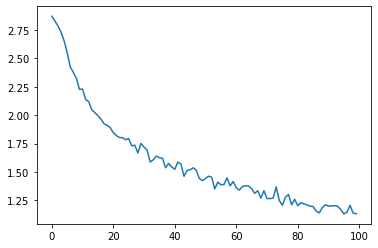

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

Evaluating the Results
======================

To see how well the network performs on different categories, we will
create a confusion matrix, indicating for every actual language (rows)
which language the network guesses (columns). To calculate the confusion
matrix a bunch of samples are run through the network with
``evaluate()``, which is the same as ``train()`` minus the backprop.




<ipython-input-16-0c78ecddaa23>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-16-0c78ecddaa23>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


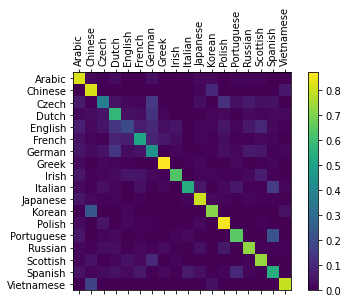

In [16]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

layer

You can pick out bright spots off the main axis that show which
languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
for Italian. It seems to do very well with Greek, and very poorly with
English (perhaps because of overlap with other languages).




Running on User Input
---------------------




In [17]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Jackson')
predict('Satoshi')
predict('Lu')
predict('Yang')


> Jackson
(-0.06) Scottish
(-3.61) English
(-4.36) Russian

> Satoshi
(-0.39) Arabic
(-1.32) Japanese
(-4.45) Polish

> Lu
(-0.14) Vietnamese
(-2.42) Korean
(-4.09) Chinese

> Yang
(-0.53) Korean
(-0.95) Chinese
(-4.84) German


# LSTM by PyTorch


Sequence Models and Long-Short Term Memory Networks
===================================================

At this point, we have seen various feed-forward networks. That is,
there is no state maintained by the network at all. This might not be
the behavior we want. Sequence models are central to NLP: they are
models where there is some sort of dependence through time between your
inputs. The classical example of a sequence model is the Hidden Markov
Model for part-of-speech tagging. Another example is the conditional
random field.

A recurrent neural network is a network that maintains some kind of
state. For example, its output could be used as part of the next input,
so that information can propogate along as the network passes over the
sequence. In the case of an LSTM, for each element in the sequence,
there is a corresponding *hidden state* $h_t$, which in principle
can contain information from arbitrary points earlier in the sequence.
We can use the hidden state to predict words in a language model,
part-of-speech tags, and a myriad of other things.


LSTMs in Pytorch
~~~~~~~~~~~~~~~~~

Before getting to the example, note a few things. Pytorch's LSTM expects
all of its inputs to be 3D tensors. The semantics of the axes of these
tensors is important. The first axis is the sequence itself, the second
indexes instances in the mini-batch, and the third indexes elements of
the input. We haven't discussed mini-batching, so lets just ignore that
and assume we will always have just 1 dimension on the second axis. If
we want to run the sequence model over the sentence "The cow jumped",
our input should look like

\begin{align}\begin{bmatrix}
   \overbrace{q_\text{The}}^\text{row vector} \\
   q_\text{cow} \\
   q_\text{jumped}
   \end{bmatrix}\end{align}

Except remember there is an additional 2nd dimension with size 1.

In addition, you could go through the sequence one at a time, in which
case the 1st axis will have size 1 also.

Let's see a quick example.



In [27]:
# Author: Robert Guthrie

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [28]:
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# initialize the hidden state.
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)

# alternatively, we can do the entire sequence all at once.
# the first value returned by LSTM is all of the hidden states throughout
# the sequence. the second is just the most recent hidden state
# (compare the last slice of "out" with "hidden" below, they are the same)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence
# "hidden" will allow you to continue the sequence and backpropagate,
# by passing it as an argument  to the lstm at a later time
# Add the extra 2nd dimension
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # clean out hidden state
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

tensor([[[-0.0187,  0.1713, -0.2944]],

        [[-0.3521,  0.1026, -0.2971]],

        [[-0.3191,  0.0781, -0.1957]],

        [[-0.1634,  0.0941, -0.1637]],

        [[-0.3368,  0.0959, -0.0538]]], grad_fn=<StackBackward>)
(tensor([[[-0.3368,  0.0959, -0.0538]]], grad_fn=<StackBackward>), tensor([[[-0.9825,  0.4715, -0.0633]]], grad_fn=<StackBackward>))


## Example: An LSTM for Part-of-Speech Tagging
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In this section, we will use an LSTM to get part of speech tags. We will
not use Viterbi or Forward-Backward or anything like that, but as a
(challenging) exercise to the reader, think about how Viterbi could be
used after you have seen what is going on.

The model is as follows: let our input sentence be
$w_1, \dots, w_M$, where $w_i \in V$, our vocab. Also, let
$T$ be our tag set, and $y_i$ the tag of word $w_i$.
Denote our prediction of the tag of word $w_i$ by
$\hat{y}_i$.

This is a structure prediction, model, where our output is a sequence
$\hat{y}_1, \dots, \hat{y}_M$, where $\hat{y}_i \in T$.

To do the prediction, pass an LSTM over the sentence. Denote the hidden
state at timestep $i$ as $h_i$. Also, assign each tag a
unique index (like how we had word\_to\_ix in the word embeddings
section). Then our prediction rule for $\hat{y}_i$ is

\begin{align}\hat{y}_i = \text{argmax}_j \  (\log \text{Softmax}(Ah_i + b))_j\end{align}

That is, take the log softmax of the affine map of the hidden state,
and the predicted tag is the tag that has the maximum value in this
vector. Note this implies immediately that the dimensionality of the
target space of $A$ is $|T|$.


### Prepare data



In [29]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


training_data = [
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
word_to_ix = {}
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
print(word_to_ix)
tag_to_ix = {"DET": 0, "NN": 1, "V": 2}

# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

{'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}


### Create the model

In [30]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

### Train the model

In [31]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
    print(tag_scores)

for epoch in range(300):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

# See what the scores are after training
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)

    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!
    print(tag_scores)

tensor([[-1.1389, -1.2024, -0.9693],
        [-1.1065, -1.2200, -0.9834],
        [-1.1286, -1.2093, -0.9726],
        [-1.1190, -1.1960, -0.9916],
        [-1.0137, -1.2642, -1.0366]])
tensor([[-0.0462, -4.0106, -3.6096],
        [-4.8205, -0.0286, -3.9045],
        [-3.7876, -4.1355, -0.0394],
        [-0.0185, -4.7874, -4.6013],
        [-5.7881, -0.0186, -4.1778]])


In [37]:
training_data

[(['The', 'dog', 'ate', 'the', 'apple'], ['DET', 'NN', 'V', 'DET', 'NN']),
 (['Everybody', 'read', 'that', 'book'], ['NN', 'V', 'DET', 'NN'])]

In [35]:
for sentence, tags in training_data:
    sentence_in = prepare_sequence(sentence, word_to_ix)
    targets = prepare_sequence(tags, tag_to_ix)
    print(sentence_in)
    print(targets)
    print("-------")

tensor([0, 1, 2, 3, 4])
tensor([0, 1, 2, 0, 1])
-------
tensor([5, 6, 7, 8])
tensor([1, 2, 0, 1])
-------


In [43]:
model.word_embeddings

Embedding(9, 6)